In [ ]:
import warnings
warnings.filterwarnings("ignore")

import torch
torch.cuda.is_available()


# Question Answering – Exploration du dataset SQuAD

Ce notebook a pour objectif de charger et explorer le dataset SQuAD
afin de comprendre la structure des données utilisées pour le
fine-tuning de modèles Transformer en question answering extractif.


## Objectifs

- Charger le dataset SQuAD à l’aide de la librairie Hugging Face Datasets
- Comprendre la structure des données (question, contexte, réponse)
- Visualiser des exemples concrets
- Initialiser le tokenizer associé au modèle Transformer


In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
import pandas as pd
import numpy as np

c:\Users\aissi\OneDrive - De Vinci\A5\UVSQ\S2\Fouille de données\qa-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chargement du dataset SQuAD

Nous utilisons le dataset SQuAD (Stanford Question Answering Dataset),
un jeu de données de référence pour le question answering extractif.


In [2]:
dataset = load_dataset("squad")
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

## Structure du dataset

Le dataset est composé de deux parties :
- un ensemble d’entraînement (`train`)
- un ensemble de validation (`validation`)


In [3]:
dataset["train"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})

In [4]:
dataset["validation"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10570
})

## Exemple d’une entrée du dataset

Chaque exemple contient :
- un contexte (paragraphe)
- une question
- une ou plusieurs réponses sous forme de span dans le contexte


In [5]:
dataset["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

## Conversion en DataFrame

Pour faciliter l’exploration des données, nous convertissons le dataset
en DataFrame pandas.


In [6]:
train_df = pd.DataFrame(dataset["train"])
train_df.head()

,id,title,context,question,answers
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'text': ['Saint Bernadette Soubirous'], 'answ..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'text': ['a copper statue of Christ'], 'answe..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'text': ['the Main Building'], 'answer_start'..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,{'text': ['a Marian place of prayer and reflec...
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,{'text': ['a golden statue of the Virgin Mary'...


In [7]:
val_df = pd.DataFrame(dataset["validation"])

## Visualisation des distributions

Observons la distribution des longueurs pour mieux comprendre
les caractéristiques du dataset.


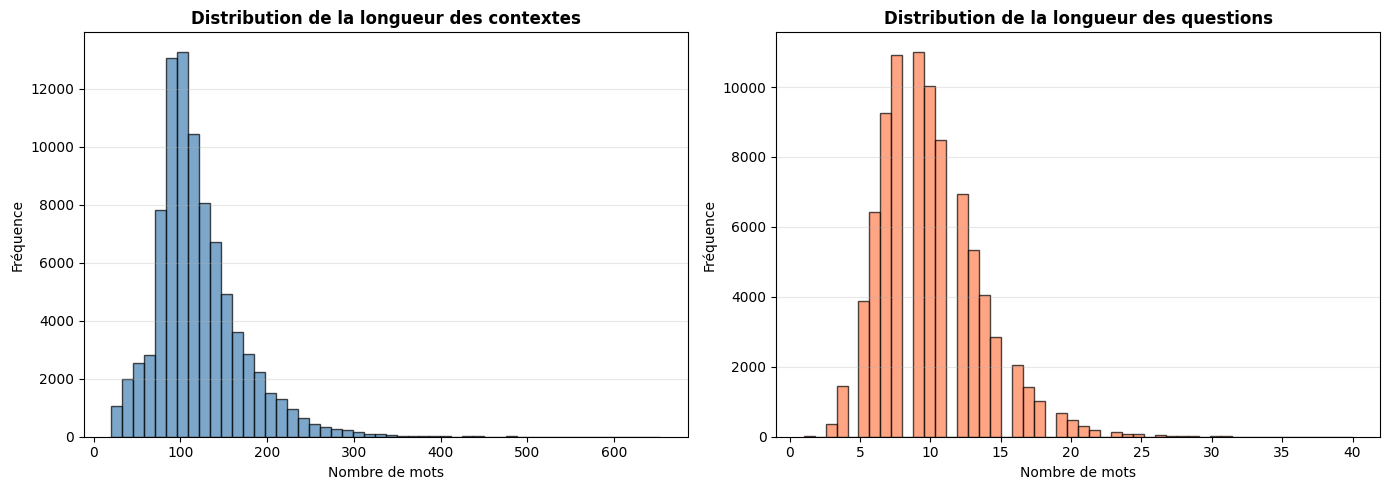

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des longueurs de contexte
axes[0].hist(train_df["context_len"], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title("Distribution de la longueur des contextes", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Nombre de mots")
axes[0].set_ylabel("Fréquence")
axes[0].grid(axis='y', alpha=0.3)

# Histogramme des longueurs de question
axes[1].hist(train_df["question_len"], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title("Distribution de la longueur des questions", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Nombre de mots")
axes[1].set_ylabel("Fréquence")
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Analyse des réponses

Dans SQuAD, la réponse n’est pas générée :
elle correspond à un **segment précis du contexte**.

Chaque réponse est définie par :
- le texte de la réponse
- l’indice de début dans le contexte


In [10]:
example = dataset["train"][0]

print("Question:", example["question"])
print("Answer:", example["answers"]["text"][0])
print("Answer start:", example["answers"]["answer_start"][0])
print("Context snippet:", example["context"][example["answers"]["answer_start"][0]:
                                     example["answers"]["answer_start"][0] + 50])


Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer: Saint Bernadette Soubirous
Answer start: 515
Context snippet: Saint Bernadette Soubirous in 1858. At the end of 


In [12]:
# Vérifier le nombre de réponses possibles pour une question
print("STRUCTURE MULTI-RÉPONSES\n")
print(f"Nombre de réponses pour cet exemple : {len(example['answers']['text'])}")
print(f"Réponses possibles : {example['answers']['text']}")

print("\nObservation sur le dataset complet :")
print(f"Nombre moyen de réponses par question : {train_df['num_answers'].mean():.2f}")
print(f"Max réponses par question : {train_df['num_answers'].max()}")


STRUCTURE MULTI-RÉPONSES

Nombre de réponses pour cet exemple : 1
Réponses possibles : ['Saint Bernadette Soubirous']

Observation sur le dataset complet :
Nombre moyen de réponses par question : 1.00
Max réponses par question : 1


**Importance des métriques adaptées** : 
Certaines questions possèdent plusieurs réponses valides. C'est pourquoi 
nous utilisons des métriques comme l'Exact Match (EM) et le F1-score 
plutôt qu'une simple accuracy binaire.

## Tokenization

Nous utilisons le tokenizer associé au modèle Transformer.
Le tokenizer permet de transformer le texte en tokens exploitables
par le réseau de neurones.


In [10]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [11]:
tokenizer(example["question"], example["context"])

{'input_ids': [101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017, 11342, 1998, 1996, 27

## Tokenization avec contraintes de longueur

Les contextes pouvant être longs, nous appliquons :
- une troncature
- une longueur maximale
- un padding


In [ ]:
inputs = tokenizer(
    example["question"],
    example["context"],
    truncation="only_second",
    max_length=384,
    stride=128,
    padding="max_length",
    return_overflowing_tokens=True,
    return_tensors="pt"
)

print("Tokénisation avec contraintes :")
print(f"  - max_length : 384")
print(f"  - stride : 128 (pour les contextes dépassant max_length)")
print(f"  - return_overflowing_tokens : True (gestion des fenêtres chevauchantes)")
print(f"\nRésultat :")
print(inputs)


{'input_ids': tensor([[  101,  2000,  3183,  2106,  1996,  6261,  2984,  9382,  3711,  1999,
          8517,  1999, 10223, 26371,  2605,  1029,   102,  6549,  2135,  1010,
          1996,  2082,  2038,  1037,  3234,  2839,  1012, 10234,  1996,  2364,
          2311,  1005,  1055,  2751,  8514,  2003,  1037,  3585,  6231,  1997,
          1996,  6261,  2984,  1012,  3202,  1999,  2392,  1997,  1996,  2364,
          2311,  1998,  5307,  2009,  1010,  2003,  1037,  6967,  6231,  1997,
          4828,  2007,  2608,  2039, 14995,  6924,  2007,  1996,  5722,  1000,
          2310,  3490,  2618,  4748,  2033, 18168,  5267,  1000,  1012,  2279,
          2000,  1996,  2364,  2311,  2003,  1996, 13546,  1997,  1996,  6730,
          2540,  1012,  3202,  2369,  1996, 13546,  2003,  1996, 24665, 23052,
          1010,  1037, 14042,  2173,  1997,  7083,  1998,  9185,  1012,  2009,
          2003,  1037, 15059,  1997,  1996, 24665, 23052,  2012, 10223, 26371,
          1010,  2605,  2073,  1996,  

**Attention : Risque de perte de réponse**

La troncature naïve (truncation=True) peut entraîner la perte de la réponse 
si celle-ci se situe au-delà de la fenêtre tokenisée (position > max_length).

C'est pourquoi le mécanisme de sliding window (stride + overflowing tokens) 
est crucial : il crée des fenêtres chevauchantes pour s'assurer que 
chaque réponse est captée dans au moins une fenêtre.

## Conclusion

Ce notebook a permis d’explorer le dataset SQuAD et de comprendre
la structure des données utilisées pour le question answering extractif.

La prochaine étape consistera à préparer les données pour
l’entraînement, en alignant les positions des réponses avec les tokens
produits par le tokenizer.
